# Artificial Intelligence II - HW3

**Sakarellos Ioannis (sdi1800167)**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import random
import os

import numpy as np

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [ ]:
def split_data(train, test, test_size=0.15):

  X_train = train[['url', 'review']]
  y_train = train[['rating']]

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, shuffle=True)

  if test != None:
    X_val = test[['url', 'review']]
    y_val = test[['rating']]

  return X_train.reset_index().drop('index', axis=1), X_val.reset_index().drop('index', axis=1), y_train.reset_index().drop('index', axis=1), y_val.reset_index().drop('index', axis=1)

In [ ]:
def process_data(X_data_set, y_data_set, remove_stop_words=False):

  X = X_data_set
  y = y_data_set

  X.drop('url', axis=1, inplace=True)
  X['review'] = X['review'].str.lower()

  X['review'].replace(r'<.*?>', ' ', regex=True, inplace=True)
  X['review'].replace(r'[^\w\s]', ' ', regex=True, inplace=True)
  X['review'].replace(r'\d', ' ', regex=True, inplace=True)
  X['review'].replace(r'\s+', ' ', regex=True, inplace=True)

  if remove_stop_words:
    nltk.download('stopwords')
    STOP_WORDS = stopwords.words('english')

    X['review'] = X['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

  y['label'] = y.apply(lambda row: 0 if row.rating < 5 else 1, axis=1)
  y.drop('rating', axis=1, inplace=True)

  return X.squeeze(), y.squeeze()

In [ ]:
def plot_curves(epoch, loss_val, loss_tr, prec_val, prec_tr, rec_val, rec_tr, f1_val, f1_tr):
  fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

  axs[0, 0].plot(epoch, loss_val)
  axs[0, 0].plot(epoch, loss_tr)
  axs[0, 0].set_ylim(bottom=0, top=1)
  axs[0, 0].legend(['Validation', 'Training'])
  axs[0, 0].set_title('Loss')

  axs[0, 1].plot(epoch, prec_val)
  axs[0, 1].plot(epoch, prec_tr)
  axs[0, 1].set_ylim(bottom=0, top=1)
  axs[0, 1].legend(['Validation', 'Training'])
  axs[0, 1].set_title('Precision Score')

  axs[1, 0].plot(epoch, rec_val)
  axs[1, 0].plot(epoch, rec_tr)
  axs[1, 0].set_ylim(bottom=0)
  axs[1, 0].legend(['Validation', 'Training'])
  axs[1, 0].set_title('Recall Score')

  axs[1, 1].plot(epoch, f1_val)
  axs[1, 1].plot(epoch, f1_tr)
  axs[1, 1].set_ylim(bottom=0)
  axs[1, 1].legend(['Validation', 'Training'])
  axs[1, 1].set_title('F1 Score')

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Artificial Intelligence II/imdb-reviews.csv', sep='\t')
test = None     # Change this to test the best performing model at the end of the notebook!

train.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


In [ ]:
X_train_original, X_val_original, y_train_original, y_val_original = split_data(train, test)

In [ ]:
X_train, y_train = process_data(X_train_original, y_train_original, remove_stop_words=True)
X_val, y_val = process_data(X_val_original, y_val_original, remove_stop_words=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Transfrom Input Data to GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-01-27 17:54:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-27 17:54:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-27 17:54:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.300d.txt'
glove_d = 300

w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

In [ ]:
from gensim.models import KeyedVectors

keyed_vectors = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

In [ ]:
X_train_glove = np.zeros((X_train.shape[0], glove_d))
X_val_glove = np.zeros((X_val.shape[0], glove_d))

for i in range(X_train.shape[0]):
  total = 0
  for word in X_train[i].split():
    if word in keyed_vectors:
      X_train_glove[i] += keyed_vectors[word]
      total += 1
  if total != 0:
    X_train_glove[i] /= total

for i in range(X_val.shape[0]):
  total = 0
  for word in X_val[i].split():
    if word in keyed_vectors:
      X_val_glove[i] += keyed_vectors[word]
      total += 1
  if total != 0:
    X_val_glove[i] /= total

y_train = np.array(y_train)
y_val = np.array(y_val)

## Define DataLoaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

class trainDataSet(Dataset):
  def __init__(self):
    self.x = torch.Tensor(X_train_glove)
    self.y = torch.LongTensor(y_train)

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples


class valDataSet(Dataset):
  def __init__(self):
    self.x = torch.Tensor(X_val_glove)
    self.y = torch.LongTensor(y_val)

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples

trainLoader = DataLoader(dataset=trainDataSet(), batch_size=256, shuffle=True)
valLoader = DataLoader(dataset=valDataSet(), batch_size=256, shuffle=True)

## Create RNN

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    """
      Wrapper module for RNN, LSTM, GRU cells using pytorch api. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, num_layers, dropout_prob, output_size, grad_clip):
        super(RNN, self).__init__()

        cells = {
        "RNN"     : nn.RNN,
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
        }

        self.cell_type = cell_type
        self.rnn = cells[cell_type](        # Pick the specific model
            input_size=input_size,          # Number of features for each time step
            hidden_size=hidden_size,        # rnn hidden units
            batch_first=True,               # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout_prob
        )
        self.grad_clip=grad_clip

        if dropout_prob != 0:
          self.dropout = nn.Dropout(dropout_prob)

        self.out = nn.Linear(hidden_size*2, output_size) # Feed forward network

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)

        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])

        return out

## Training Method

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def train_model(epochs, optimizer, dataloaderTRAIN, dataloaderVAL, cost_func, model, device='cpu', print_out=True):
  device = torch.device(device)

  list_loss_T = []
  list_loss_V = []

  list_f1_T = []
  list_f1_V = []

  list_precision_T = []
  list_precision_V = []

  list_recall_T = []
  list_recall_V = []

  list_epoch = []

  for epoch in range(epochs):
    if print_out:
      print('Epoch No ', epoch, '\n================', sep='')

    scores_TRAIN = []
    targets_TRAIN = []

    for batch, (data, targets) in enumerate(dataloaderTRAIN):
      data = data.to(device=device)
      targets = targets.to(device=device)

      b_data = data.view(data.shape[0], -1, glove_d)

      scores = model(b_data)
      loss = cost_func(scores, targets)

      scores_TRAIN.append(scores)
      targets_TRAIN.append(targets)

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), model.grad_clip)
      optimizer.step()

      if print_out:
        print('Batch No ', batch, ',\tloss is ', loss.item(), sep='')

    scores_TRAIN = torch.cat(scores_TRAIN, 0).cpu()
    targets_TRAIN = torch.cat(targets_TRAIN, 0).cpu()

    model.eval()

    scores_VAL = []
    targets_VAL = []

    with torch.no_grad():
      for data, targets in dataloaderVAL:
        data = data.to(device=device)
        targets = targets.to(device=device)

        b_data = data.view(data.shape[0], -1, glove_d)

        scores = model(b_data)

        scores_VAL.append(scores)
        targets_VAL.append(targets)

    scores_VAL = torch.cat(scores_VAL, 0).cpu()
    targets_VAL = torch.cat(targets_VAL, 0).cpu()

    model.train()

    _, pred_TRAIN = scores_TRAIN.max(1)

    loss_T = cost_func(scores_TRAIN, targets_TRAIN).item()
    f1_T = f1_score(targets_TRAIN, pred_TRAIN, average='macro')
    prec_T = precision_score(targets_TRAIN, pred_TRAIN)
    rec_T = recall_score(targets_TRAIN, pred_TRAIN)

    list_loss_T.append(loss_T)
    list_f1_T.append(f1_T)
    list_precision_T.append(prec_T)
    list_recall_T.append(rec_T)

    _, pred_VAL = scores_VAL.max(1)

    loss_V = cost_func(scores_VAL, targets_VAL).item()
    f1_V = f1_score(targets_VAL, pred_VAL, average='macro')
    prec_V = precision_score(targets_VAL, pred_VAL)
    rec_V = recall_score(targets_VAL, pred_VAL)

    list_loss_V.append(loss_V)
    list_f1_V.append(f1_V)
    list_precision_V.append(prec_V)
    list_recall_V.append(rec_V)

    list_epoch.append(epoch)

    if print_out:
      print('')

  return model, list_epoch, list_loss_T, list_loss_V, list_f1_T, list_f1_V, list_precision_T, list_precision_V, list_recall_T, list_recall_V

## Evaluation Method

In [ ]:
def eval_model(dataloader, cost_func, model, device='cpu'):
  device = torch.device(device)

  model.eval()
  with torch.no_grad():

    scores_all = []
    targets_all = []

    for data, targets in dataloader:
      data = data.to(device=device)
      targets = targets.to(device=device)

      b_data = data.view(data.shape[0], -1, glove_d)
      scores = model(b_data)

      scores_all.append(scores)
      targets_all.append(targets)

    scores_all = torch.cat(scores_all, 0).cpu()
    targets_all = torch.cat(targets_all, 0).cpu()

    _, pred = scores_all.max(1)

    loss = cost_func(scores_all, targets_all)
    f1 = f1_score(targets_all, pred, average='macro')
    prec = precision_score(targets_all, pred)
    rec = recall_score(targets_all, pred)
    mat = confusion_matrix(targets_all, pred)

    print('Loss:\t\t\t', loss, '\n')
    print('F1 Macro-Averaged Score:', f1)
    print('Precision Score:\t', prec)
    print('Recall Score:\t\t', rec, '\n')
    print('Confusion Matrix:\n', mat, '\n')

  model.train()

## Trying Different Model Implementations

In [ ]:
epochs = 30
learning_rate = 0.01

optimizer = torch.optim.Adam
loss_function = nn.CrossEntropyLoss

### RNN cells

#### Different hidden_size

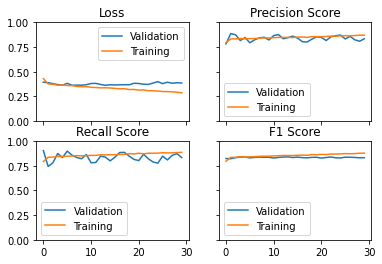

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

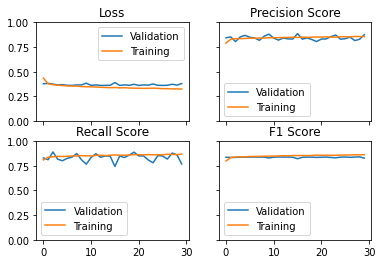

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=4, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

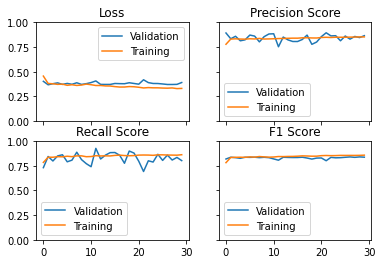

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=64, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

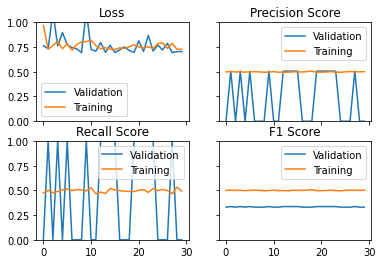

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=256, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different num_layer

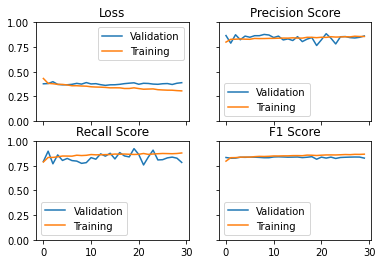

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

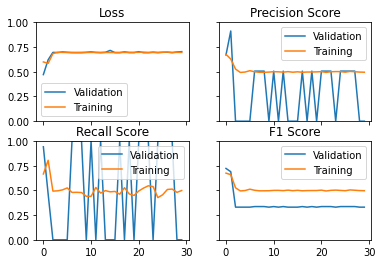

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

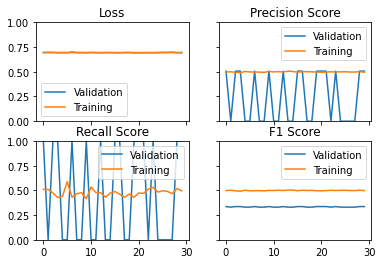

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=20, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different dropout_prob

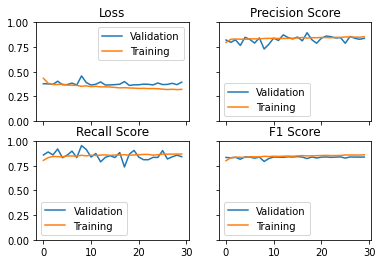

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

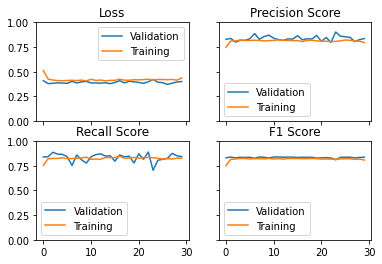

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

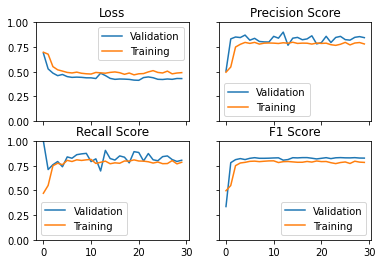

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.7, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

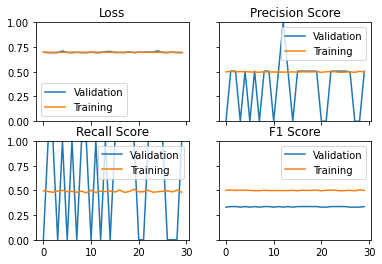

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.8, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

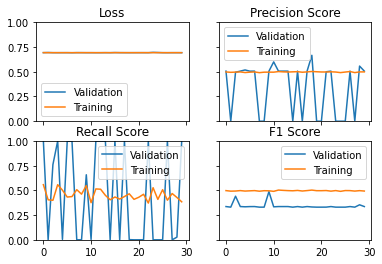

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=1, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different grad_clip

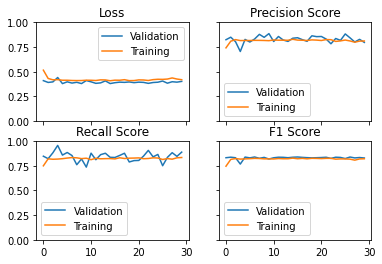

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

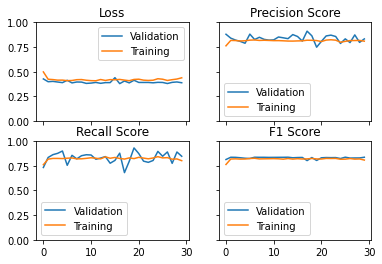

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=1).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

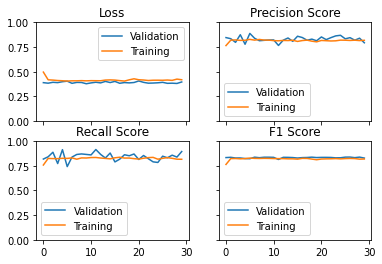

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=3).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

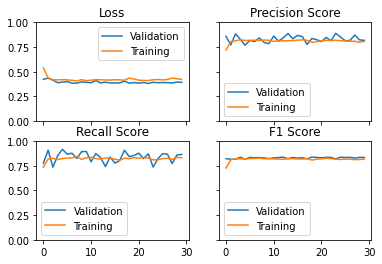

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=8).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

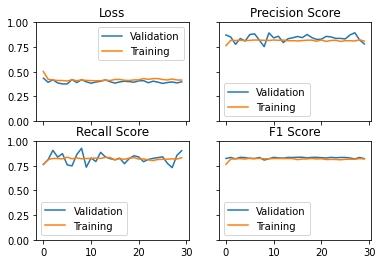

In [ ]:
model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=10).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

### LSTM cells

In [ ]:
learning_rate = 0.001

#### Different hidden_size

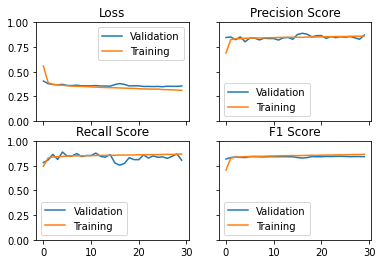

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=16, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

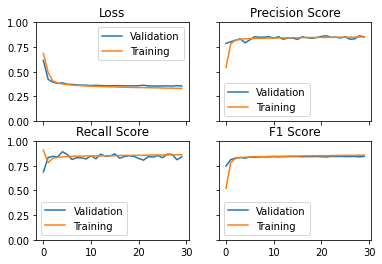

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=4, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

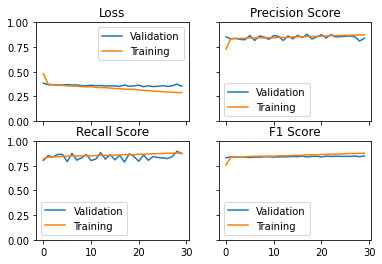

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=256, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

KeyboardInterrupt: ignored

#### Different num_layer

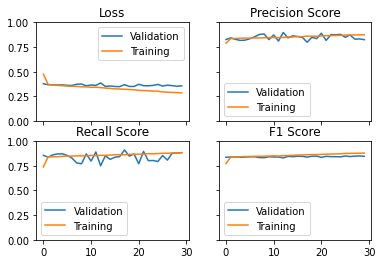

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

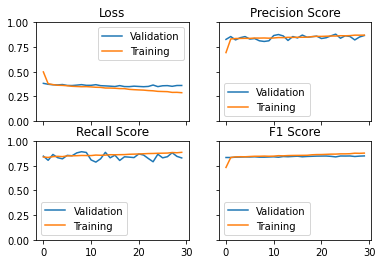

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=5, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different dropout_prob

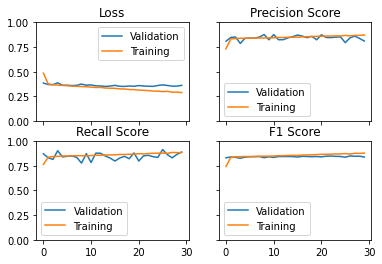

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=5, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

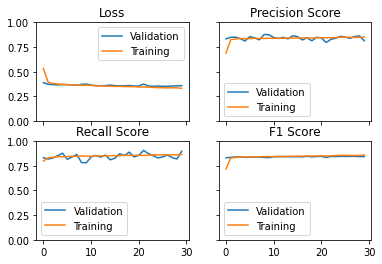

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different grad_clip

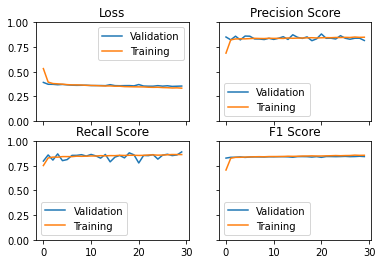

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

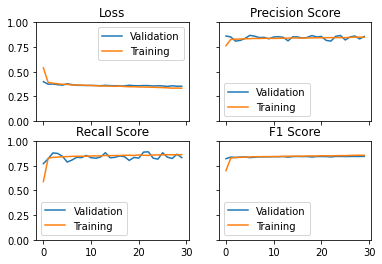

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=1).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

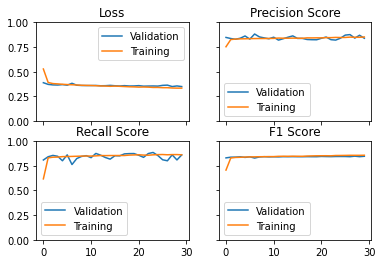

In [ ]:
model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=8).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

### GRU cells

In [ ]:
learning_rate = 0.001

#### Different hidden_size

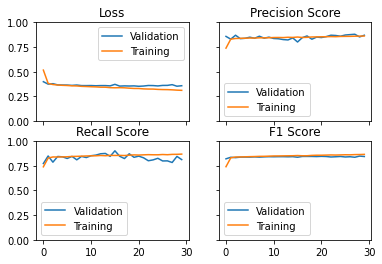

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

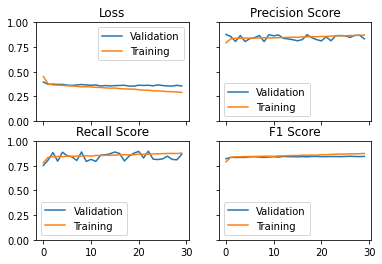

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=64, num_layers=3, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different num_layer

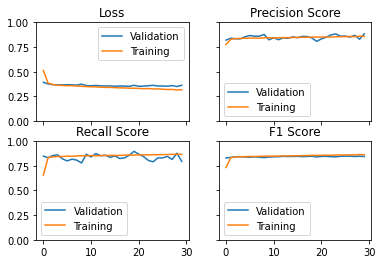

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

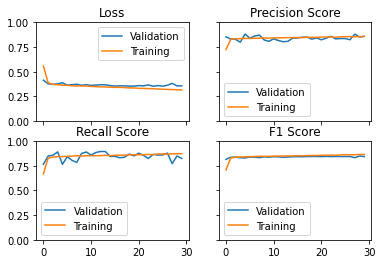

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different dropout_prob

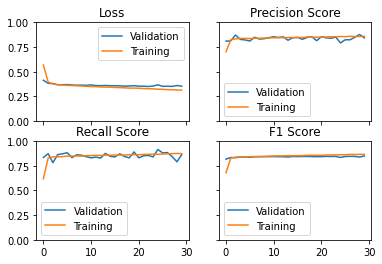

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


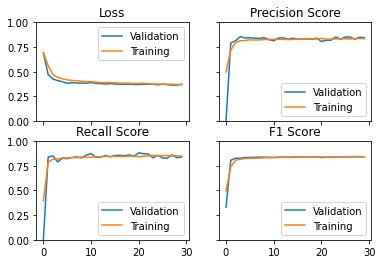

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0.5, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

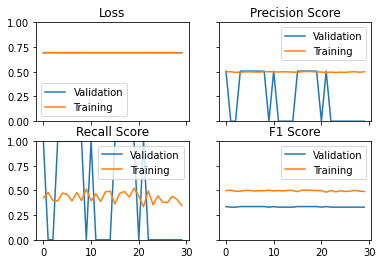

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0.7, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

#### Different grad_clip

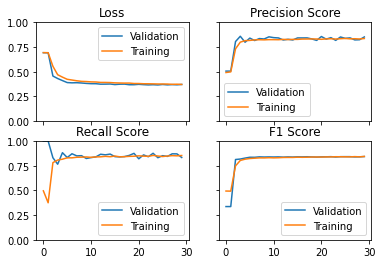

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0.5, output_size=2, grad_clip=1).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

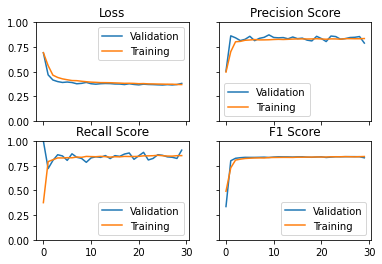

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0.5, output_size=2, grad_clip=3).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

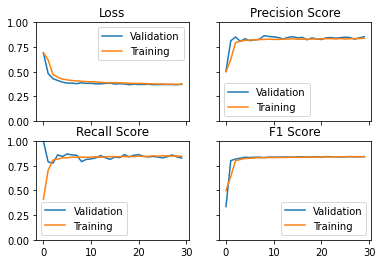

In [ ]:
model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0.5, output_size=2, grad_clip=8).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

plot_curves(epochsL, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

## Scores for the Best Model of Each Implementation

### RNN Cells

In [ ]:
learning_rate = 0.01

model = RNN(cell_type="RNN", input_size=glove_d, hidden_size=16, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=3).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

eval_model(dataloader=valLoader, cost_func=loss_function(), model=model)

Loss:			 tensor(0.3992) 

F1 Macro-Averaged Score: 0.8266989897156172
Precision Score:	 0.7985706723133933
Recall Score:		 0.8819058754750073 

Confusion Matrix:
 [[2570  761]
 [ 404 3017]] 



### LSTM Cells

In [ ]:
learning_rate = 0.001

model = RNN(cell_type="LSTM", input_size=glove_d, hidden_size=64, num_layers=5, dropout_prob=0.5, output_size=2, grad_clip=5).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

eval_model(dataloader=valLoader, cost_func=loss_function(), model=model)

Loss:			 tensor(0.3611) 

F1 Macro-Averaged Score: 0.8414783650301709
Precision Score:	 0.8660853316723762
Recall Score:		 0.8129201987722888 

Confusion Matrix:
 [[2901  430]
 [ 640 2781]] 



### GRU Cells

In [ ]:
learning_rate = 0.001

model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0.5, output_size=2, grad_clip=8).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

eval_model(dataloader=valLoader, cost_func=loss_function(), model=model)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss:			 tensor(0.3670) 

F1 Macro-Averaged Score: 0.8422592381395493
Precision Score:	 0.8481087470449172
Recall Score:		 0.8389359836305174 

Confusion Matrix:
 [[2817  514]
 [ 551 2870]] 



## Best Perfofming Model

In [ ]:
# Execute this cell after having changed the test file on the 6th cell of this notebook to test the best performing model!

learning_rate = 0.001

model = RNN(cell_type="GRU", input_size=glove_d, hidden_size=16, num_layers=10, dropout_prob=0.5, output_size=2, grad_clip=8).to(torch.device('cpu'))

model, epochsL, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer(model.parameters(), lr=learning_rate), dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=loss_function(), model=model, print_out=False)

eval_model(dataloader=valLoader, cost_func=loss_function(), model=model)